DSCI 100 008 Project
Group 8

In [1]:
#Loading Packages
library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)

set.seed(999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
ff_raw <- read_csv("https://raw.githubusercontent.com/MingTxm/DSCI100_GroupProject/main/forestfires.csv")
head(ff_raw)

Rows: 517 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


In [3]:
# Filtering Relevant Data
ff <- ff_raw |>
    select(month, ISI, temp, wind) |>
    arrange(desc(month)) |>
    drop_na()
head(ff)
nrow(ff)

# Splitting the Data
ff_split <- initial_split(ff, prop = 0.75, strata = ISI)
    ff_train <- training(ff_split)
    ff_test <- testing(ff_split)

month,ISI,temp,wind
<chr>,<dbl>,<dbl>,<dbl>
sep,7.0,13.1,5.4
sep,7.1,22.8,4.0
sep,7.1,17.8,7.2
sep,22.6,19.3,4.0
sep,7.0,21.3,2.2
sep,9.2,26.4,4.5


[1] 517

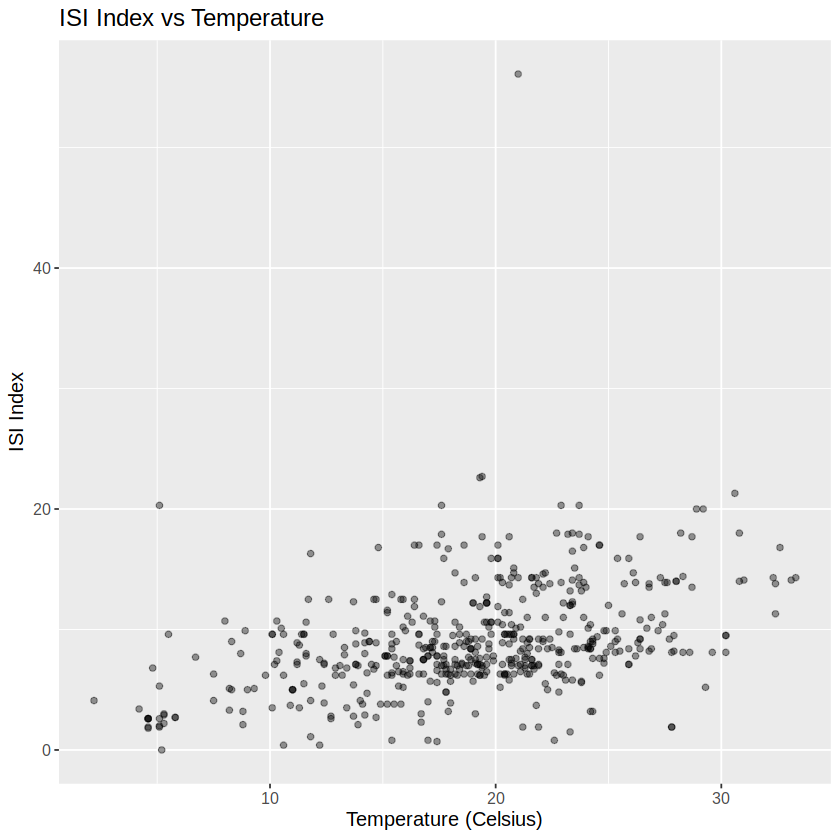

In [4]:
# ISI vs Temperature Plot #
ff_temp_plot <- ff |>
    ggplot(aes(x = temp, y = ISI)) +
        geom_point(alpha = 0.4) +
        labs(x = "Temperature (Celsius)", y = "ISI Index", title = "ISI Index vs Temperature") +
        theme(text = element_text(size = 12))
ff_temp_plot

In [5]:
## Temp Regression Model ##

ff_train_temp <- ff_train |>
    select(ISI, temp)
head(ff_train_temp)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

temp_recipe <- recipe(ISI ~ temp, data = ff_train_temp)

temp_fit <- workflow()|>
    add_recipe(temp_recipe) |>
    add_model(lm_spec) |>
    fit(data = ff_train_temp)

ISI,temp
<dbl>,<dbl>
6.3,18.2
6.2,12.9
6.3,17.8
4.8,22.8
3.2,17.9
3.2,24.2


.pred,month,ISI,temp
<dbl>,<chr>,<dbl>,<dbl>
8.735212,sep,7.1,17.8
11.574093,sep,9.2,26.4
10.418734,sep,13.9,22.9
9.164345,sep,9.2,19.1
10.385724,sep,8.1,22.8
9.659499,sep,5.8,20.6


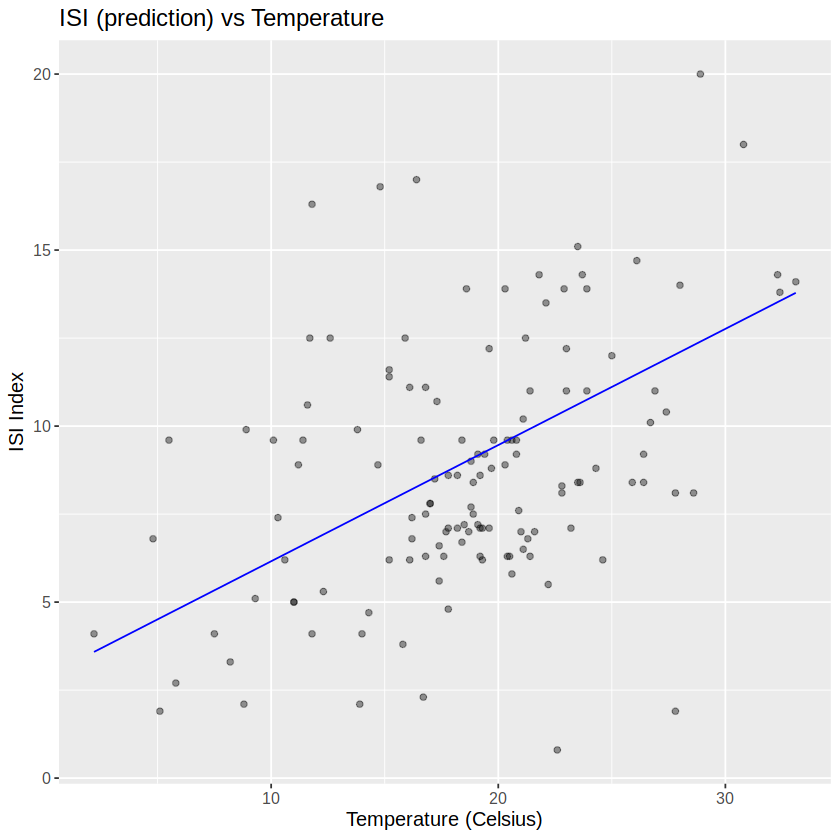

In [6]:
## Temperature Prediction ##

temp_prediction <- temp_fit |>
    predict(ff_test) |>
    bind_cols(ff_test) |>
    select(.pred, month, ISI, temp)
head(temp_prediction)

## Plotting Temperature Prediction ##

temp_prediction_plot <- temp_prediction |>
    ggplot(aes(x = temp, y = ISI)) +
        geom_point(alpha = 0.4) +
        geom_line(mapping = aes(x = temp, y = .pred), color = "blue") +
        labs(x = "Temperature (Celsius)", y = "ISI Index", title = "ISI (prediction) vs Temperature") +
        theme(text = element_text(size = 12))
temp_prediction_plot

In [7]:
## Temp Prediction Accuracy

temp_prediction_results <- temp_fit |>
    predict(ff_test) |>
    bind_cols(ff_test) |>
    metrics(truth = ISI, estimate = .pred)

temp_rmspe <- temp_prediction_results |>
     filter(.metric == "rmse") |>
     select(.estimate) |>
     pull()
temp_rmspe


[1] 3.285285

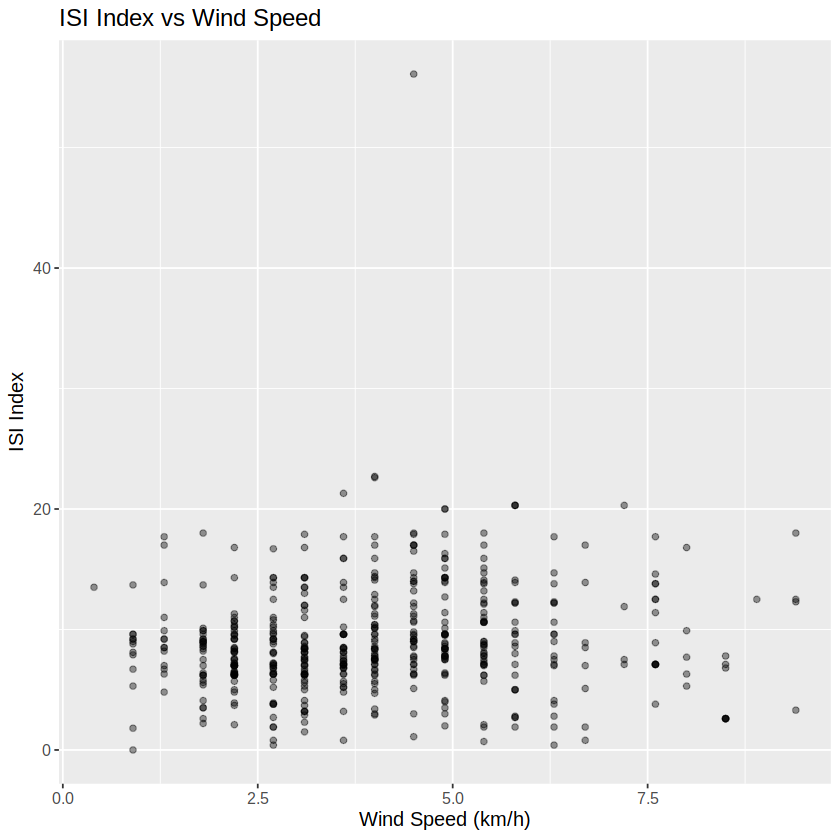

In [8]:
## ISI vs Wind Plot ##
ff_wind_plot <- ff |>
    ggplot(aes(x = wind, y = ISI)) +
        geom_point(alpha = 0.4) +
        labs(x = "Wind Speed (km/h)", y = "ISI Index", title = "ISI Index vs Wind Speed") +
        theme(text = element_text(size = 12))
ff_wind_plot

In [9]:
## Wind Regression Model ##
ff_train_wind <- ff_train |>
    select(ISI, wind)
head(ff_train_wind)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

wind_recipe <- recipe(ISI ~ wind, data = ff_train_wind)

wind_fit <- workflow()|>
    add_recipe(wind_recipe) |>
    add_model(lm_spec) |>
    fit(data = ff_train_wind)

ISI,wind
<dbl>,<dbl>
6.3,4.5
6.2,4.9
6.3,4.9
4.8,3.6
3.2,3.1
3.2,3.6


.pred,month,ISI,wind
<dbl>,<chr>,<dbl>,<dbl>
10.064333,sep,7.1,7.2
9.263936,sep,9.2,4.5
9.530735,sep,13.9,5.4
8.730338,sep,9.2,2.7
8.997137,sep,8.1,3.6
8.463539,sep,5.8,1.8


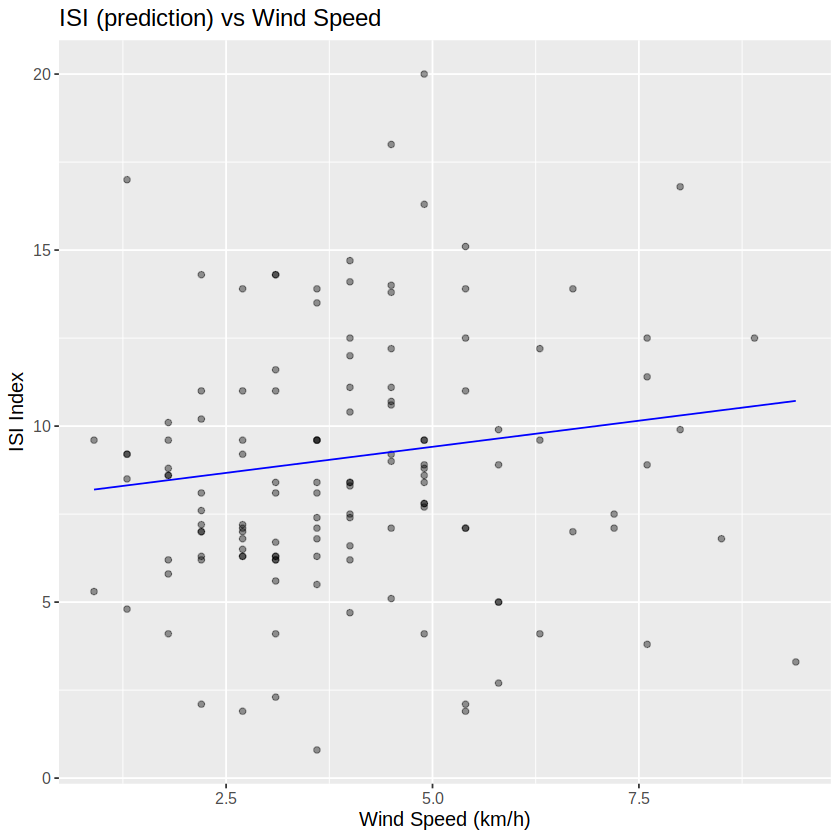

In [10]:
## Wind Prediction ##

wind_prediction <- wind_fit |>
    predict(ff_test) |>
    bind_cols(ff_test) |>
    select(.pred, month, ISI, wind)
head(wind_prediction)

## Plotting Temperature Prediction ##

wind_prediction_plot <- wind_prediction |>
    ggplot(aes(x = wind, y = ISI)) +
        geom_point(alpha = 0.4) +
        geom_line(mapping = aes(x = wind, y = .pred), color = "blue") +
        labs(x = "Wind Speed (km/h)", y = "ISI Index", title = "ISI (prediction) vs Wind Speed") +
        theme(text = element_text(size = 12))
wind_prediction_plot

In [11]:
## Wind Pred Accuracy ##

wind_prediction_results <- wind_fit |>
    predict(ff_test) |>
    bind_cols(ff_test) |>
    metrics(truth = ISI, estimate = .pred)

wind_rmspe <- wind_prediction_results |>
     filter(.metric == "rmse") |>
     select(.estimate) |>
     pull()
wind_rmspe

[1] 3.568901